# Exploratory Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
import os
from sqlalchemy import create_engine
from sqlalchemy import types

from dotenv import load_dotenv # env variables
load_dotenv(verbose=True)

In [84]:
SQLALCHEMY_DATABASE_URI = os.getenv('DATABASE_URL')
engine = create_engine(SQLALCHEMY_DATABASE_URI)

## Returning Reviews
Group data by Customer ID, visualize the attributes

what kind of visualization to use? 
1. use what i have now
   + stacked area chart: count on y, continuous on x, nested category counts as value
     + tell:
       + initial view: x: a week time, y: count, stack: different review counts
       + second view: for a group of reviewers, the star rating they gives?
         + 
2. use new but simple
    + boxplot: x: review times as category, y: review counts as box; dropdown menu to select a numeric attribute
      + tell: some attributes show difffernce between nmber of review times, some not
    + lollipop plot: x: count of a word, y: each word, dropdown to select a number of review times category
      + tell: word using difference in review body, compare across different times
      + or use barplot

3. use new and interactive

what is interesting to visualize? 
1. once vs. twice vs.  multiple times: boxplot with numeric values, i.e. star rating, nutrients
2. review counts distribution: histograms, given a time peroid
3. negative verified 
4. what headline do they use? the difference between review once vs. multiple times
5. length of review body, difference between once and multiple times

alternatvies:
+ make the stacked area chart connect 

### Data for Ridgeline Chat
`when to leave a review`
+ x-axis: day of a week
+ y-axis: category of times a user leaving a review
+ value: smoothed p value on review counts

In [85]:
start_date = '2014-01-01'
end_date = '2014-12-31'

In [86]:
query = \
"""
SELECT 
    customer_id,
    review_id, 
    review_date
FROM 
    food_reviews
WHERE 
    verified_purchase LIKE 'Y'
    AND review_date IS NOT NULL
    AND review_date BETWEEN '{0}' AND '{1}'
ORDER BY
    review_date
""".format(start_date, end_date)
sub = pd.read_sql(query, con=engine)
sub.shape

(38254, 3)

In [96]:
# 3 to 11
n_times = 6

In [97]:
index = []
for times in range(1, n_times):
    for weekday in range(7):
        index.append((times, weekday))
len(index) # (number of category) * (number of days)

14

In [98]:
# more than 10 times, reset as 10
data = sub.assign(times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))\
    .assign(times=lambda df: np.where(df.times >= n_times-1, n_times-1, df.times))\
    .groupby(['times', sub.review_date.dt.dayofweek])[['review_id']].count()\
    .reindex(index, fill_value=0)\
    .reset_index(drop=False)\
    .assign(byTimesSum=lambda d: d.groupby('times')[['review_id']].transform('sum'))\
    .assign(p=lambda d: d.review_id / d.byTimesSum)\
    .assign(byTimesMaxP=lambda d: d.groupby('times')[['p']].transform(max))\
    .assign(p_peak=lambda d: d.p / d.byTimesMaxP)\
    .assign(p_lag1=lambda d: d.groupby('times')[['p_peak']].shift(-1))\
    .assign(p_lead1=lambda d: d.groupby('times')[['p_peak']].shift(1))\
    .assign(p_smooth=lambda d: (d.p_lag1 + d.p_peak + d.p_lead1) / 3)\
    .drop(['review_id', 'byTimesSum', 'byTimesMaxP', 'p_lag1', 'p_lead1',], axis=1)\
    .rename(columns={'times': 'review_times', 'review_date': 'weekday'})\
    .fillna(method='ffill', axis=1)

In [99]:
# samle for first 3 rows
data.iloc[:3, :].to_json(orient='records')
# data.to_json('local.json', orient='records', )

'[{"review_times":1.0,"weekday":0.0,"p":0.1544062733,"p_peak":1.0,"p_smooth":1.0},{"review_times":1.0,"weekday":1.0,"p":0.1509833209,"p_peak":0.9778315195,"p_smooth":0.9863630257},{"review_times":1.0,"weekday":2.0,"p":0.1515123226,"p_peak":0.9812575574,"p_smooth":0.9639930136}]'

## Subset on main nutrients
+ Amazon Reivew attributes & Product Main Nutrients
+ including: ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']

In [10]:
main = ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', \
        'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']
sub = df.loc[:, df.columns[:13].tolist()+main]

# extract only data with nutrients and remove outliners
# sub = sub[((sub.energy_100g.notna()) & (sub.energy_100g < 1000))]
sub = sub[((sub.energy_100g.notna()) & (sub.energy_100g < 3000))]

# get data after 2010
sub = sub[sub.review_date.dt.year >= 2010].reset_index(drop=True)
sub.shape

(137698, 21)

In [11]:
sub.energy_100g.mean()
# average energy per 100 g

1183.096259001277

In [12]:
sub[['review_date', 'star_rating']].groupby(sub.review_date.dt.year).count()
# not many data before 2005

,review_date,star_rating
review_date,,
2010,3130,3130
2011,5434,5434
2012,10420,10420
2013,28060,28060
2014,44152,44152
2015,46502,46502


## Users who buy more than once 
+ using 'customer_id' to identify users who buy once vs. more than once
+ only about 22% users buy more than once
+ what about the ratings on products? differe between two groups?

+ what's the distribution difference?
+ what are they buying, in terms of the nutrients? in terms of the product categories?
+ 

In [13]:
tmp = sub.copy()
tmp['times'] = sub.groupby('customer_id')[['review_id']].transform('count')

once = tmp[tmp.times == 1]
more = tmp[tmp.times > 1]

once.shape, more.shape

((107021, 22), (30677, 22))

In [14]:
tmp[tmp.times != 1].shape[0] / tmp.shape[0]

0.22278464465714826

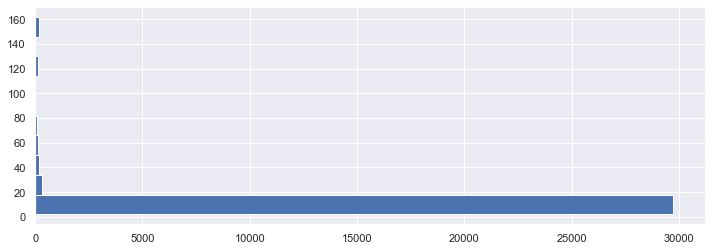

In [15]:
plt.figure(figsize=(12, 4))
plt.hist(tmp[tmp.times > 1].times, orientation='horizontal')
plt.show()

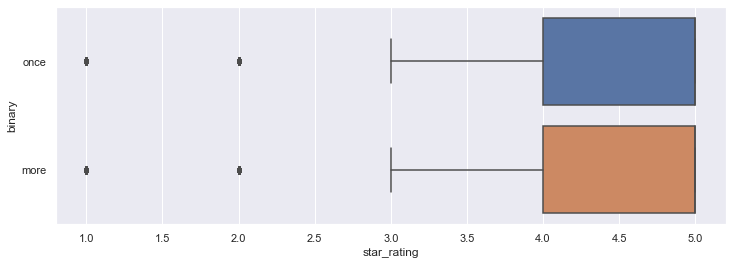

In [16]:
plt.figure(figsize=(12, 4))
tmp.assign(binary=lambda df: df.times.apply(lambda d: 'once' if d == 1 else 'more'))\
    .pipe((sns.boxplot, 'data'), x='star_rating', y='binary')
# plt.savefig('./figures/buy-times.png', bbox_inches='tight', dpi=300)
plt.show()
# no difference in rating

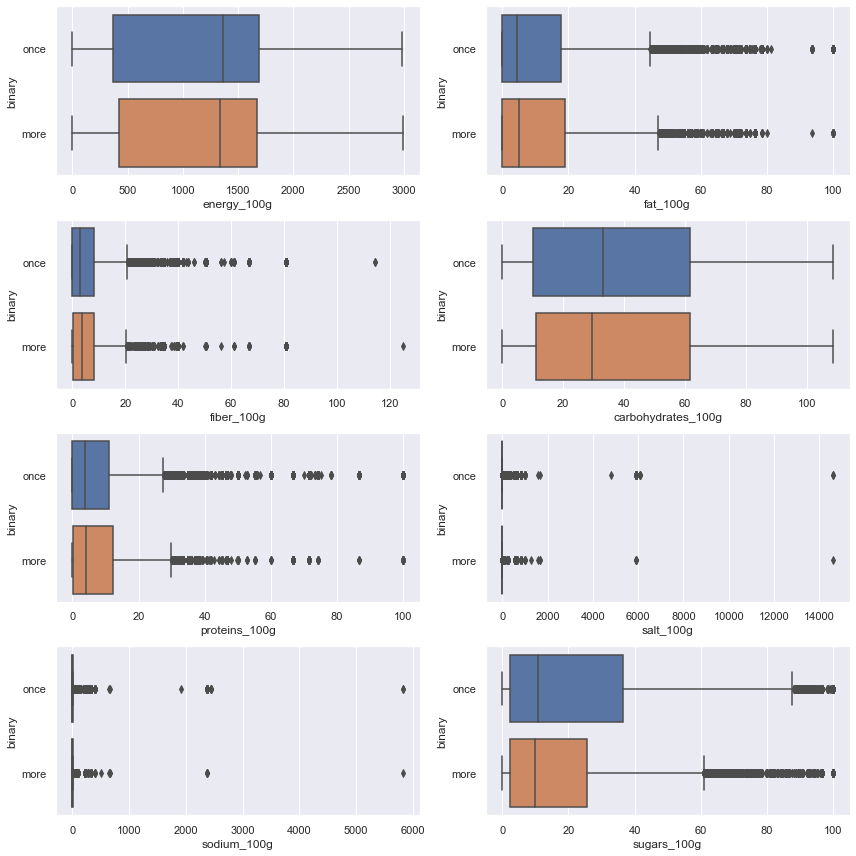

In [22]:
p = tmp.assign(binary=lambda df: df.times.apply(lambda d: 'once' if d == 1 else 'more'))

fig, axs = plt.subplots(4,2, figsize=(12, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(8):
    sns.boxplot(x=main[i], y='binary', data=p, ax=axs[i])
#     axs[i].set_title(main[i])
plt.tight_layout()
# plt.savefig('./figures/buy-times-nutrients.png', bbox_inches='tight', dpi=300)
plt.show()
# only some difference in sugar content

### Word Clouds to compare between two user groups
+ https://www.datacamp.com/community/tutorials/wordcloud-python
+ https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911

In [23]:
import re
from wordcloud import WordCloud, STOPWORDS

In [31]:
stopwords = set(STOPWORDS)
# stopwords.update(["drink", "now", "wine", "flavor", "flavors"])
stopwords.update(["good", "love", "make", "use", "flavor", "peanut", 
                  "butter", "well", "really", "taste", "delicious", "great", 
                  "one", "stuff", "product", ""])

In [32]:
text = ""
for string in once.review_body:
    if string is not np.nan:
        text += " "
        text += re.sub(r'[^\w\s]', '', string.lower())
len(text)

21964454

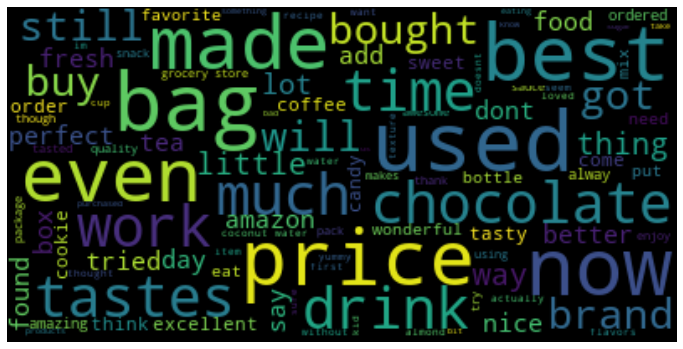

In [33]:
plt.figure(figsize=(12, 12))
wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stopwords).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
wordcloud.to_file("./figures/wcloud_once.png")

In [35]:
text2 = ""
for string in more.review_body:
    if string is not np.nan:
        text2 += " "
        text2 += re.sub(r'[^\w\s]', '', string.lower())
len(text2)

8443628

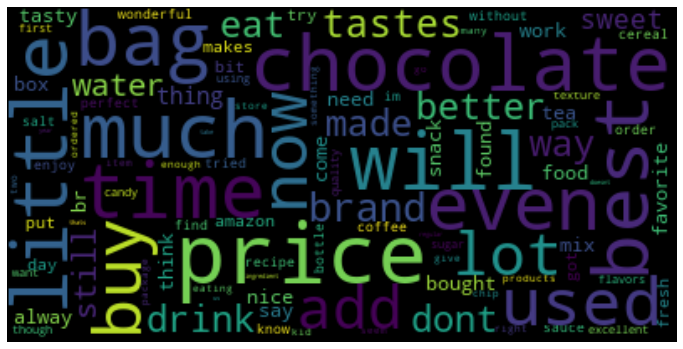

In [36]:
plt.figure(figsize=(12, 12))
wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stopwords).generate(text2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
wordcloud.to_file("./figures/wcloud_more.png")

In [28]:
df.main_category_en.unique()

array(['Fats', nan, 'Plant-based foods and beverages', 'Beverages',
       'Snacks', 'Energy-80', 'Meats', 'Precooked-meat', 'Groceries',
       'Fruit juices', 'Breakfasts', 'Sandwiches', 'Vinegars',
       'Dietary supplements', 'Coffee-creamer',
       'Cocoa and chocolate powders', 'Spreads',
       'es:escamas-de-sal-marina', 'Products without gluten',
       'fr:sauce-piquante', 'Cooking helpers', 'Canned-precooked-meat',
       'Meals', 'Biscuits and cakes', 'es:gominolas', 'Dairies',
       'fr:the-royal', 'Nonpareil-capers', 'Sweeteners',
       'fr:the-vert-aromatise', 'es:cereales-desayuno', 'Rice-candy',
       'Peanut-butter-cup', 'Tomato-ketchup', 'Himalayan-salts',
       'Tonkatsu-sauce', 'es:galletas', 'Natural-spring-water',
       'fr:sport-nutrition', 'Seafood', 'ro:bomboane',
       'fr:tablette-chocolat', 'Dark-almonds-chocolate', 'Fish eggs',
       'Easter food', 'Desserts', 'Syrups', 'Black-truffle-oil', 'Deo',
       'es:cacao-puro', 'Blackcurrent-juice-drink'